# MSA 7D:(None Mass) Shooting Analysis: GVA Data Exploration (Wisconsin, 2024)

In [1]:
import json
import pandas as pd
import numpy as np
import random
from pathlib import Path

import seaborn as sns
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import myst_nb
import wikipedia as wp
import math



## Loading Data & Formatting Dates for Analysis

In [49]:
# Disable scientific notation globally
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams['axes.formatter.use_mathtext'] = False
mpl.rcParams['axes.formatter.limits'] = (-999, 999)  # forces normal numbers
random.seed(33)

In [3]:
df = pd.read_csv('MSA Data\GVA_Wisconsin_24.csv')
scope = 'Wisconsin, 2024'
len(df)

885

In [4]:
df.head(3)

,Incident ID,Incident Date,State,City Or County,Address,Victims Killed,Victims Injured,Suspects Killed,Suspects Injured,Suspects Arrested,Operations
0,3106104,"December 31, 2024",Wisconsin,Tomah,Mary Kay Ave,0,1,0,0,1,NaN
1,3105982,"December 31, 2024",Wisconsin,Milwaukee,4800 block of N 32nd St,0,1,0,0,0,NaN
2,3107038,"December 31, 2024",Wisconsin,Beloit,1100 block of Jackson St,0,1,0,0,0,NaN


In [5]:
df.dtypes

Incident ID            int64
Incident Date         object
State                 object
City Or County        object
Address               object
Victims Killed         int64
Victims Injured        int64
Suspects Killed        int64
Suspects Injured       int64
Suspects Arrested      int64
Operations           float64
dtype: object

In [6]:
df['date'] = pd.to_datetime(df['Incident Date'], format = '%B %d, %Y', errors = 'coerce')

In [7]:
df = df.rename(columns={
    'City Or County': 'city',
    'Address': 'address',
    'Victims Killed': 'v_killed',
    'Victims Injured': 'v_injured',
    'Suspects Killed': 's_killed',
    'Suspects Injured': 's_injured',
    'Suspects Arrested': 's_arrested',
    'Incident ID': 'id'
    })
df.head(2)

,id,Incident Date,State,city,address,v_killed,v_injured,s_killed,s_injured,s_arrested,Operations,date
0,3106104,"December 31, 2024",Wisconsin,Tomah,Mary Kay Ave,0,1,0,0,1,NaN,2024-12-31
1,3105982,"December 31, 2024",Wisconsin,Milwaukee,4800 block of N 32nd St,0,1,0,0,0,NaN,2024-12-31


In [8]:
df['dow'] = df['date'].dt.day_name().str[:3]
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month_name().str[:3]
df['week'] = df['date'].dt.isocalendar().week
df['t_kill'] = df['v_killed'] + df['s_killed']
df['t_inj'] = df['v_injured'] + df['s_injured']
df['total'] = df['t_inj'] + df['t_kill']

In [10]:
df = df[[ 'date', 'dow','day', 'month', 'week','city', 'address', 'v_killed',
       'v_injured', 's_killed', 's_injured', 's_arrested', 't_kill', 't_inj', 'total', 'id']]
df.tail(2)

,date,dow,day,month,week,city,address,v_killed,v_injured,s_killed,s_injured,s_arrested,t_kill,t_inj,total,id
883,2024-01-01,Mon,1,Jan,1,Milwaukee,S 44th St and W Forest Home Ave,0,1,0,0,0,0,1,1,2791603
884,2024-01-01,Mon,1,Jan,1,Milwaukee,N 9th St and W Chambers St,0,1,0,0,0,0,1,1,2791593


## Largest Shooting Incidents in the State in 2024

In [11]:
df.nlargest(10, 'total').reset_index(drop=True)

,date,dow,day,month,week,city,address,v_killed,v_injured,s_killed,s_injured,s_arrested,t_kill,t_inj,total,id
0,2024-06-09,Sun,9,Jun,23,Madison,433 W Johnson St,0,12,0,0,1,0,12,12,2935144
1,2024-12-16,Mon,16,Dec,51,Madison,4901 E Buckeye Rd,2,6,1,0,0,3,6,9,3094796
2,2024-07-22,Mon,22,Jul,30,Milwaukee,6901 W Vienna Ave,1,8,0,0,1,1,8,9,2974973
3,2024-08-03,Sat,3,Aug,31,Milwaukee,3853 N Richards St,0,5,0,0,0,0,5,5,2986051
4,2024-07-28,Sun,28,Jul,30,Milwaukee,9200 block of W Silver Spring Dr,0,5,0,0,0,0,5,5,2981150
5,2024-09-05,Thu,5,Sep,36,Milwaukee,N 91st St and W Custer Ave,0,3,0,1,1,0,4,4,3016430
6,2024-08-22,Thu,22,Aug,34,Milwaukee,4001 W North Ave,1,3,0,0,1,1,3,4,3002869
7,2024-07-06,Sat,6,Jul,27,Milwaukee,Doctor Martin Luther King Jr Dr and 6th St,0,4,0,0,0,0,4,4,2961005
8,2024-06-26,Wed,26,Jun,26,Milwaukee,5912 W Oklahoma Ave,0,4,0,0,2,0,4,4,2950871
9,2024-02-25,Sun,25,Feb,8,Milwaukee,N 51st St and W Center St,2,0,1,1,3,3,1,4,2837937


## Shooting Incidents over the Calendar Year - 2024

In [12]:
day_colours = {
    "Mon": "#a2bffe",  # pastel blue
    "Tue": "#7af9ab",  # Sea Foam Green
    "Wed": "#ffff14",  # Yellow
    "Thu": "#fdaa48",  # Light Orange    
    "Fri": "#ff474c",  # Light Red
    "Sat": "#910951",  # Reddish Purple
    "Sun": "#632de9",  # Purple Blue
}

In [13]:
month_colours = {
    "Jan": "#4C72B0", "Feb": "#6BAED6", "Mar": "#9ECAE1",
    "Apr": "#41AB5D", "May": "#74C476", "Jun": "#A1D99B",
    "Jul": "#FEC44F", "Aug": "#FE9929", "Sep": "#EC7014",
    "Oct": "#E6550D", "Nov": "#A63603", "Dec": "#756BB1"
}

Text(0.5, 0, 'Month')

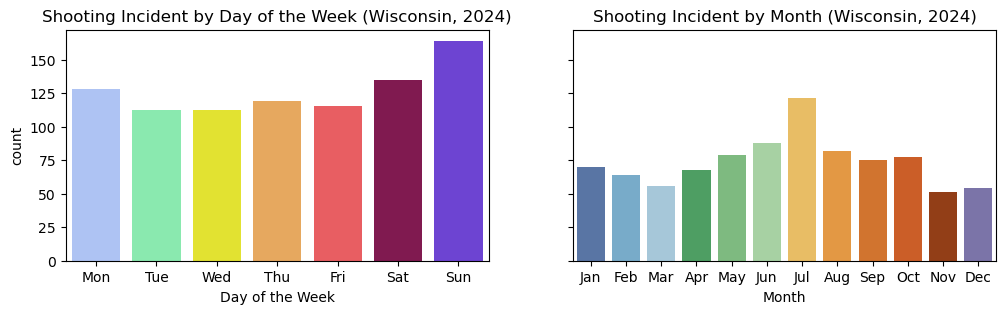

In [14]:
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3), sharey=True)

sns.countplot(df, x='dow', ax=ax1, palette = day_colours, hue='dow',
              order=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
             ).set_title('Shooting Incident by Day of the Week (' + scope + ')')
ax1.set_xlabel("Day of the Week")

sns.countplot(df, x='month', ax=ax2,palette = month_colours, hue='month',
              order=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov', 'Dec']
             ).set_title('Shooting Incident by Month (' + scope + ')')
ax2.set_xlabel("Month")
#plt.set_title('Mass Shooting Incident by Day of the Week & Month (\'14-\'24)')


**Day of the Week:** As with the data for Minnesota, we notice when we look at shooting incidents in general, and particularly in one of the states where gun crime is less prevalent, the difference between shooting activity during the week and at weekends is not so great. Here with the 2024 data from Wisonsin, we see that other than Sunday, the other incidents are much more evenly spread over the remaining days.

**Month of the Year:** If we look at the monthly profile we can see that Wisonsin's shooting incidents in 2024 seems to fit the general pattern we have seen over all the data for shootings by state and mass shootings nationally, with a general increase over the summer months and a slight uptick in December & January, but hear we see a much more marked peak of events in July.

Text(0.5, 1.0, 'Shooting Incident by Week (Wisconsin, 2024)')

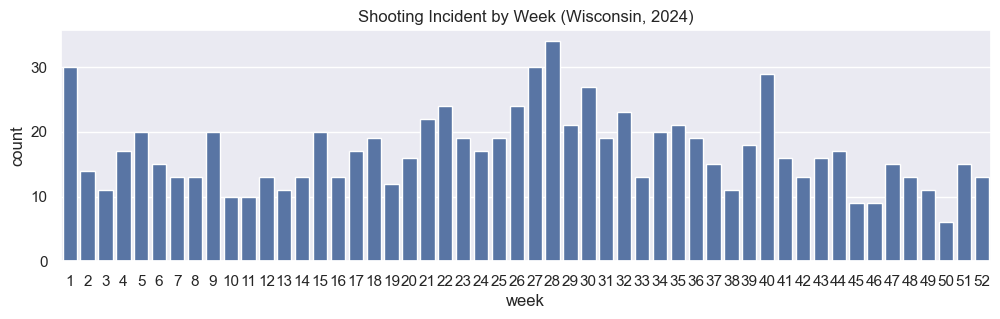

In [16]:
sns.set_theme()
plt.figure(figsize=(12,3))
sns.countplot(df, x='week', order=range(1,53), legend=False,).set_title('Shooting Incident by Week (' + scope + ')')

**Week # of the Year:** Week #28 had the most shooting incidents in Wisonsin in 2024 fitting the general pattern of more incidents in the summer months closely followed by Week #27, but also Week #1, and then Week#40. Week#1 is generally higher than the median due to activity around New Year celebrations. Week #40 saw much more activity than would be expected compared to neighbouring weeks, so this week may merit further investigation to see if there was any particular pattern of activity that related to such an uptick in incidents between Sept 30th and Oct 6th 2024, particularly as there were no holidays or special events we are aware of during that week.

Text(0.5, 1.0, 'Shooting Incident by Day of Month (Wisconsin, 2024)')

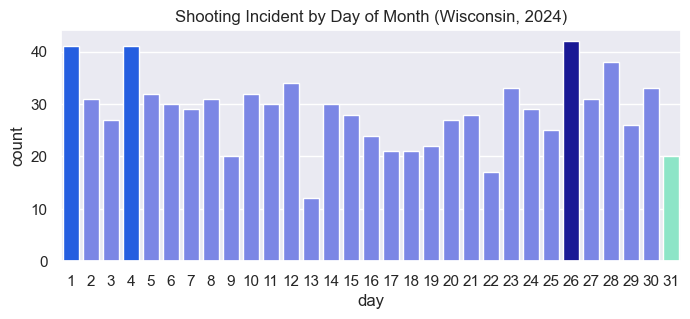

In [17]:
sns.set_theme()
plt.figure(figsize=(8,3))

all_days = sorted(df['day'].unique())
highlight_day = 31    
base_color = '#6a79f7'       # Cornflower Blue
highlight_color = "#7ef4cc" # Turquoise

day_palette = {day: base_color for day in all_days}
day_palette[highlight_day] = highlight_color
day_palette[26] = '#0504aa' #Royal Blue
day_palette[1] = '#0652ff' # Electric Blue
day_palette[4] = '#0652ff' # Electric Blue
sns.countplot(df, x='day', order=range(1,32), palette=day_palette, hue = 'day', legend=False,).set_title('Shooting Incident by Day of Month (' + scope + ')')

**Day of the Month**
* In Wisconsin, the 26th was the date with the most Shooting incidents, closely **followed by the 1st and 4th where we might expect more activity due to the holidays of January 1st (5 incidents), and July 4th respectively (6 incidents)**.
* From our analysis of the dates and weekends in 2024 for Minnesota, we noted that the 26th was one of the dates with only 2 weekend days over the year and with no Federal holidays on the 26th, we have no obvious explanantion for more incidents occurring on the 26th.   
* N.B. Again the 31st has the fewest number of incidents due to there being fewer 31sts than any other date.

## Days of Rage - Dates of 2024 with the highest number of Shooting Incidents in the State

In [24]:
rage_days = df.groupby(['day','month','dow']).agg(
    no_inc = pd.NamedAgg(column="t_kill", aggfunc="count"),
    total_inj = pd.NamedAgg(column="t_inj", aggfunc="sum"),
    total_kld = pd.NamedAgg(column="t_kill", aggfunc="sum"), 
    total_inj_kill = pd.NamedAgg(column="total", aggfunc="sum")
).reset_index()
rage_days.nlargest(10, 'no_inc').reset_index(drop=True)

,day,month,dow,no_inc,total_inj,total_kld,total_inj_kill
0,14,May,Tue,8,8,0,8
1,25,Aug,Sun,8,8,2,10
2,1,Mar,Fri,7,7,1,8
3,10,Apr,Wed,7,6,3,9
4,14,Jul,Sun,7,10,0,10
5,26,Jun,Wed,7,12,1,13
6,26,May,Sun,7,6,1,7
7,29,Jul,Mon,7,6,1,7
8,30,Sep,Mon,7,6,1,7
9,2,Jun,Sun,6,5,1,6


**Day of the Year:** In 2024 in Wisconsin, much like the data for Minnesota, there were no single days with significantly more shooting incidents than most of the others. We have 8 incidents, occurring on 2 days and the next 7 days with 7 incidents, with around half of the days having either 1 or 2 incidents. There is no apparent significance suggested by the dates of the days with the most incidents although they **generally centre around the summer months and there are 4 Sundays**, which would match our expectations from the Weekly and Monthly analysis.

In [25]:
len(rage_days) # Check total of days that included a shooting incident as data started from incidents not dates.

334

Text(0.5, 0, 'Total Number of Incidents in a Day')

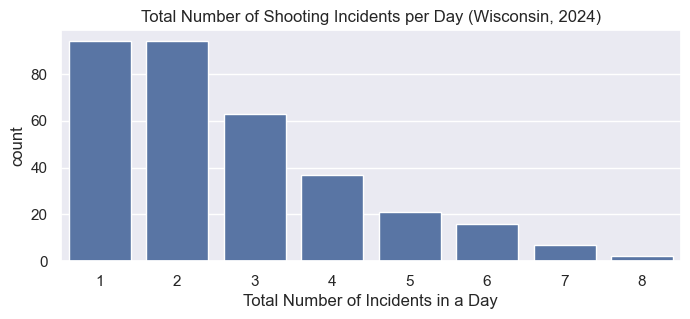

In [26]:
sns.set_theme()
plt.figure(figsize=(8,3))
sns.countplot(rage_days, x='no_inc').set_title('Total Number of Shooting Incidents per Day (' + scope + ')')
plt.xlabel ('Total Number of Incidents in a Day')

* Because this dataset was originally aggregated from rows of shooting incidents, days of the year when no shooting incidents took place are not represented in the data. It's worth noting that there were **32 days when no shooting incidents occurred** (366 - 334).
* With Wisconsin experiencing more shooting incidents in 2024 than Minnesota (885 vs 516), with a random distribution over the year we would expect **the number of days of no shootings to reduce and the probability of having more shootings in a single day would increase**, so the distribution of number of incidents seems broadly to agree with those principles.

In [32]:
months=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul','Aug','Sep','Oct','Nov', 'Dec']
rage_days['month'] = pd.Categorical(rage_days['month'], categories=months, ordered=True)
rage_days[(rage_days['day'] == 26)].sort_values(by='month')

,day,month,dow,no_inc,total_inj,total_kld,total_inj_kill
274,26,Jan,Fri,1,1,0,1
273,26,Feb,Mon,3,3,0,3
277,26,Mar,Tue,2,2,0,2
270,26,Apr,Fri,2,3,0,3
278,26,May,Sun,7,6,1,7
276,26,Jun,Wed,7,12,1,13
275,26,Jul,Fri,3,3,0,3
271,26,Aug,Mon,4,3,1,4
281,26,Sep,Thu,4,4,0,4
280,26,Oct,Sat,6,4,3,7


**Review of Incidents on the 26th**: As we saw previously there are no standout dates that contributed significantly to the 26th being the date with the most incidents, and the general pattern over the year seems to match the state trend with more incidents in Summer months tailing off to fewer in Winter. Having 2 days with 7 incidents (May and June) and 1 day with 6 (October) has contributed significantly to the total for that date, but there is no signals to suggest this would be anything other than an accumulation of coincidences.

## Analysis of number of Victims Killed and Injured per Shooting Incident

(-0.5, 4.5)

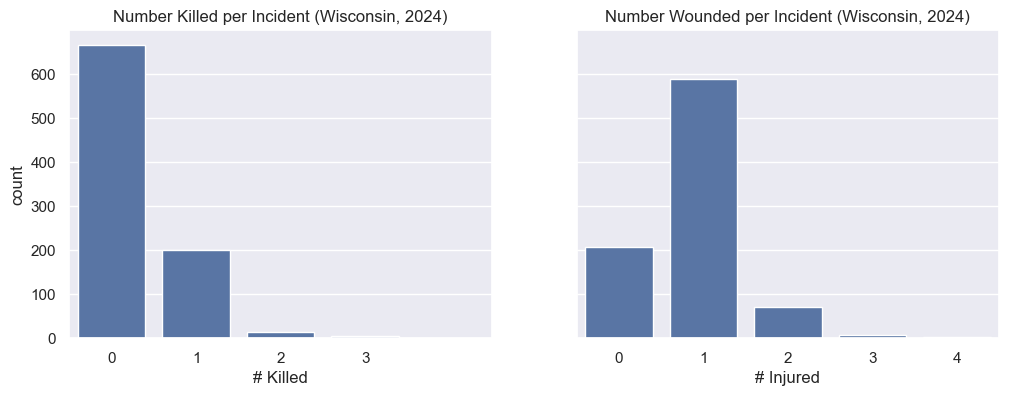

In [33]:
# Set up the matplotlib figure
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

sns.countplot(df, x='t_kill', ax=ax1).set_title('Number Killed per Incident (' + scope + ')')
ax1.set_xlabel("# Killed")
ax1.set_xlim(-0.5, 4.5)
sns.countplot(df, x='t_inj', ax=ax2).set_title('Number Wounded per Incident (' + scope + ')')
ax2.set_xlabel("# Injured")
ax2.set_xlim(-0.5, 4.5)

* **In 75% of reported shooting incidents nobody died** (666 out of 885), nobody getting injured is less common but is still just shy of 1 in 4 with 23% (208 of 885), and **thankfully the proportion of incidents where more than 2 people get killed (0.45%) or injured (1.8%) is rare for events of this significance**.

In [35]:
df.t_kill.value_counts(), df.t_inj.value_counts()

(t_kill
 0    666
 1    200
 2     15
 3      4
 Name: count, dtype: int64,
 t_inj
 1     589
 0     208
 2      72
 3       8
 4       3
 5       2
 6       1
 8       1
 12      1
 Name: count, dtype: int64)

In [36]:
counts = pd.crosstab(df['v_killed'], df['v_injured'])

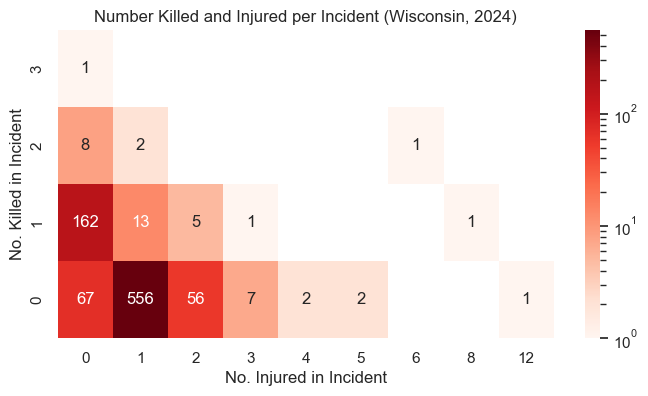

In [37]:
sns.set_style("white")
plt.figure(figsize=(8,4))
ax = sns.heatmap(counts, 
                 annot=True, 
                 fmt="d", 
                 norm=LogNorm(),
                 cmap="Reds")
ax.set_ylabel('No. Killed in Incident')
ax.set_xlabel('No. Injured in Incident')
ax.invert_yaxis()
plt.grid(False)
plt.title('Number Killed and Injured per Incident (' + scope + ')')
plt.show()

In [41]:
percentages = counts / counts.values.sum() * 100
#perc_focus = percentages.loc[0:4, 0:6]

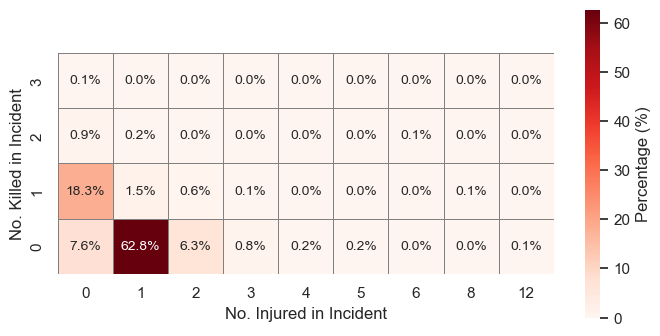

In [42]:
annot = percentages.map(lambda v: f"{v:.1f}%")

fig, ax = plt.subplots(figsize=(8,4))
sns.heatmap(
    percentages,
    ax=ax,
    annot=annot,    # preformatted strings
    fmt='',         # use the strings exactly (no extra formatting)
    cmap='Reds',
    cbar_kws={'label': 'Percentage (%)'},
    square=True,
    linewidths=0.5,
    linecolor='gray',
    annot_kws={'fontsize':10}
)

# flip so that the first row (y=0) appears at the bottom
ax.invert_yaxis()
ax.set_ylabel('No. Killed in Incident')
ax.set_xlabel('No. Injured in Incident')
plt.show()

In [43]:
s_counts = pd.crosstab(df['s_killed'], df['s_injured'])

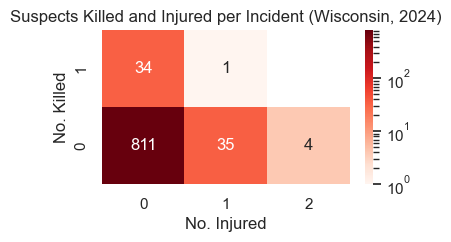

In [44]:
sns.set_style("white")
plt.figure(figsize=(4,2))
ax = sns.heatmap(s_counts, 
                 annot=True, 
                 fmt="d", 
                 norm=LogNorm(),
                 cmap="Reds")
ax.set_ylabel('No. Killed')
ax.set_xlabel('No. Injured')
ax.invert_yaxis()
plt.grid(False)
plt.title('Suspects Killed and Injured per Incident (' + scope + ')')
plt.show()

In [45]:
sia_counts = pd.crosstab(df['s_injured'], df['s_arrested'])

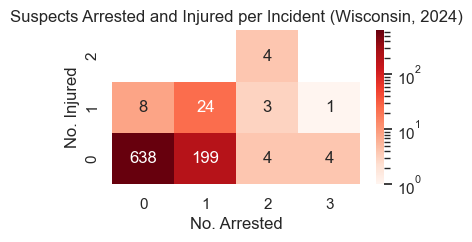

In [46]:
sns.set_style("white")
plt.figure(figsize=(4,2))
ax = sns.heatmap(sia_counts, 
                 annot=True, 
                 fmt="d", 
                 norm=LogNorm(),
                 cmap="Reds")
ax.set_ylabel('No. Injured')
ax.set_xlabel('No. Arrested')
ax.invert_yaxis()
plt.grid(False)
plt.title('Suspects Arrested and Injured per Incident (' + scope + ')')
plt.show()

In [50]:
no_vict = df[(df['v_killed'] == 0) & (df['v_injured'] == 0)]
no_vict.sample(5)

,date,dow,day,month,week,city,address,v_killed,v_injured,s_killed,s_injured,s_arrested,t_kill,t_inj,total,id
843,2024-01-18,Thu,18,Jan,3,Spring Valley,S1450 County Rd CC,0,0,0,0,0,0,0,0,2806817
157,2024-10-07,Mon,7,Oct,41,East Troy,Wilmers Grove Dr,0,0,0,1,0,0,1,1,3043482
173,2024-10-04,Fri,4,Oct,40,Exeland,NaN,0,0,0,1,0,0,1,1,3040428
536,2024-06-04,Tue,4,Jun,23,Janesville,12 N Washington St,0,0,1,0,0,1,0,1,2931378
780,2024-02-15,Thu,15,Feb,7,Milwaukee,5966 N 35th St,0,0,0,0,0,0,0,0,3129198


* Of the 5 sampled cases above where there was no harm to victims, **2 involved guns being taken in to a school and the other 3 involved Police standoffs with a suspect**, one where police shot and injured the suspect, one where the suspect shot and injured himself (presumed accidently) and the third where the suspect committed suicide.

In [51]:
sus_counts = pd.crosstab(no_vict['s_killed'], no_vict['s_injured'])

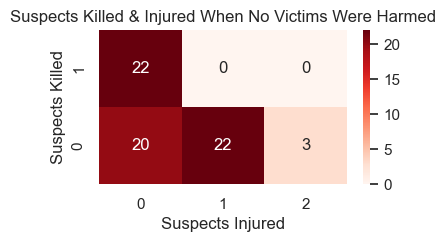

In [53]:
plt.figure(figsize=(4,2))
ax = sns.heatmap(sus_counts, 
                 annot=True, 
                 fmt="d", 
                 cmap="Reds")

ax.invert_yaxis()
ax.set_ylabel('Suspects Killed')
ax.set_xlabel('Suspects Injured')
plt.title('Suspects Killed & Injured When No Victims Were Harmed')
plt.show()

In [54]:
justice = no_vict[(no_vict.s_arrested > 1)]
justice.nlargest(5, 's_arrested')

,date,dow,day,month,week,city,address,v_killed,v_injured,s_killed,s_injured,s_arrested,t_kill,t_inj,total,id
576,2024-05-23,Thu,23,May,21,Milwaukee,3000 N Sherman Blvd,0,0,0,0,3,0,0,0,2920726
17,2024-12-23,Mon,23,Dec,52,Milwaukee,3700 block of W Lisbon Ave,0,0,0,2,2,0,2,2,3100456
492,2024-06-20,Thu,20,Jun,25,Milwaukee,I-43 ALT and W Keefe Ave,0,0,0,2,2,0,2,2,2945496
650,2024-04-21,Sun,21,Apr,16,Milwaukee,1627 N 29th St,0,0,0,2,2,0,2,2,2886587
864,2024-01-06,Sat,6,Jan,1,Milwaukee,N 12th St and W Wright St,0,0,0,1,2,0,1,1,2796190


* The first incident above involved Police officers responding to a fight between 3 men who were apparently armed (although the report does not say that they had guns). The men were ultimatley chased and arrested, but during the chase an **officer's gun went off in an accidental discharge** - nobody was harmed by the shot. 

In [55]:
no_harm_done = no_vict[(no_vict['s_killed'] == 0) & (no_vict['s_injured'] == 0) & (no_vict['s_arrested'] == 0)]
no_harm_done

,date,dow,day,month,week,city,address,v_killed,v_injured,s_killed,s_injured,s_arrested,t_kill,t_inj,total,id
40,2024-12-09,Mon,9,Dec,50,Madison,2222 E Washington Ave,0,0,0,0,0,0,0,0,3096236
246,2024-09-04,Wed,4,Sep,36,Chippewa Falls,750 Tropicana Blvd,0,0,0,0,0,0,0,0,3015740
780,2024-02-15,Thu,15,Feb,7,Milwaukee,5966 N 35th St,0,0,0,0,0,0,0,0,3129198
843,2024-01-18,Thu,18,Jan,3,Spring Valley,S1450 County Rd CC,0,0,0,0,0,0,0,0,2806817
866,2024-01-05,Fri,5,Jan,1,Milwaukee (West Allis),2465 S 84th St,0,0,0,0,0,0,0,0,2796194


**Nobody Hurt:** Of the 5 incidents, 4 involved gun's being taken into school, but no shots fired. And the last incident involved the theft of 6 handguns from a gun store.
